In [1]:
import os
import numpy as np
import torch

In [2]:
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import TSP
from interface import run_concorde
from tsp_ep import run_tsp_ep_batch, run_tsp_ep


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def shift_left_to_right(arr):
    zero_idx = np.where(arr == 0)[0][0]
    arr = np.concatenate((arr[zero_idx:], arr[:zero_idx]))
    num_nodes = len(arr)
    arr = np.append(arr, num_nodes)
    return arr

def preprocessing(tour):
    batch_size = tour.shape[0]
    tour_list = []
    for i in range(batch_size):
        tour_list.append(shift_left_to_right(tour[i]))
    tour_np = np.array(tour_list)
    return tour_np

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

In [4]:
def plot_tsp(x, tour, tour2=None, markersize=5):
    """
    Plot the TSP solution on matplotlib axis ax1.
    """
    x = x.cpu().numpy()
    tour = tour.cpu().numpy()
    
    if tour2 is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    else:
        fig, ax1 = plt.subplots(figsize=(10, 10))
        ax2 = None

    # Plot the first tour (REINFORCE)
    for i in range(x.shape[0]):
        ax1.plot(x[i, 0], x[i, 1], 'o', markersize=markersize, markerfacecolor='r')
    for i in range(x.shape[0]):
        ax1.annotate(str(tour[i]), (x[tour[i], 0], x[tour[i], 1]))
    for i in range(x.shape[0] - 1):
        ax1.arrow(x[tour[i], 0], x[tour[i], 1], x[tour[i + 1], 0] - x[tour[i], 0], x[tour[i + 1], 1] - x[tour[i], 1], head_width=0.01)
    ax1.arrow(x[tour[-1], 0], x[tour[-1], 1], x[tour[0], 0] - x[tour[-1], 0], x[tour[0], 1] - x[tour[-1], 1], head_width=0.01)
    ax1.set_title('REINFORCE: Total distance {:.2f}'.format(
        sum(np.linalg.norm(x[tour[i]] - x[tour[i + 1]]) for i in range(x.shape[0] - 1)) + np.linalg.norm(x[tour[-1]] - x[tour[0]])
    ))

    # Plot the second tour (CONCORDE) if provided
    if tour2 is not None:
        for i in range(x.shape[0]):
            ax2.plot(x[i, 0], x[i, 1], 'o', markersize=markersize, markerfacecolor='r')
        for i in range(x.shape[0]):
            ax2.annotate(str(tour2[i]), (x[tour2[i], 0], x[tour2[i], 1]))
        for i in range(x.shape[0] - 1):
            ax2.arrow(x[tour2[i], 0], x[tour2[i], 1], x[tour2[i + 1], 0] - x[tour2[i], 0], x[tour2[i + 1], 1] - x[tour2[i], 1], head_width=0.01)
        ax2.arrow(x[tour2[-1], 0], x[tour2[-1], 1], x[tour2[0], 0] - x[tour2[-1], 0], x[tour2[0], 1] - x[tour2[-1], 1], head_width=0.01)
        ax2.set_title('CONCORDE: Total distance {:.2f}'.format(
            sum(np.linalg.norm(x[tour2[i]] - x[tour2[i + 1]]) for i in range(x.shape[0] - 1)) + np.linalg.norm(x[tour2[-1]] - x[tour2[0]])
        ))
        
def plot_tspd(x, tour1, tour2=None, markersize=5):
    pass

In [6]:
# model, _ = load_model('pretrained/cvrp_100/')
path = 'tspd/tsp_'
num_nodes = 20 # 20, 50, 100; 100은 21epoch까지만 있음

model, _ = load_model(path + str(num_nodes) + '/')
torch.manual_seed(1234)
dataset = TSP.make_dataset(size = num_nodes, num_samples=1)

/home/comet/research/attention-learn-to-route/utils/functions.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(load_path, map_location=lambda storage, 

  [*] Loading model from tspd/tsp_20/epoch-99.pt


/home/comet/research/attention-learn-to-route/utils/functions.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_data = torch.load(


In [7]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1000)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tour = pi[0]

x_, y_ = batch[:,:,0], batch[:,:,1]
alpha = 2.0
tspd_cost, truck_tour, drone_tour = run_tsp_ep_batch(preprocessing(pi), x_, y_, alpha)
tspd_cost, truck_tour, drone_tour = tspd_cost[0], truck_tour[0], drone_tour[0]

In [8]:
#NOTE Get Concorde Baseline Score 
opt_costs = []
x_ = batch[0][:,0].cpu().numpy()
y_ = batch[0][:,1].cpu().numpy()
opt_tour, opt_len = run_concorde(x_, y_)
opt_tour_ = np.append(opt_tour, num_nodes + 1)
opt_tour_ -= 1
opt_tour -= 1
alpha = 2.0
opt_cost, opt_truck_tour, opt_drone_tour = run_tsp_ep(opt_tour_, x_, y_, alpha)

import gc; gc.collect()

55

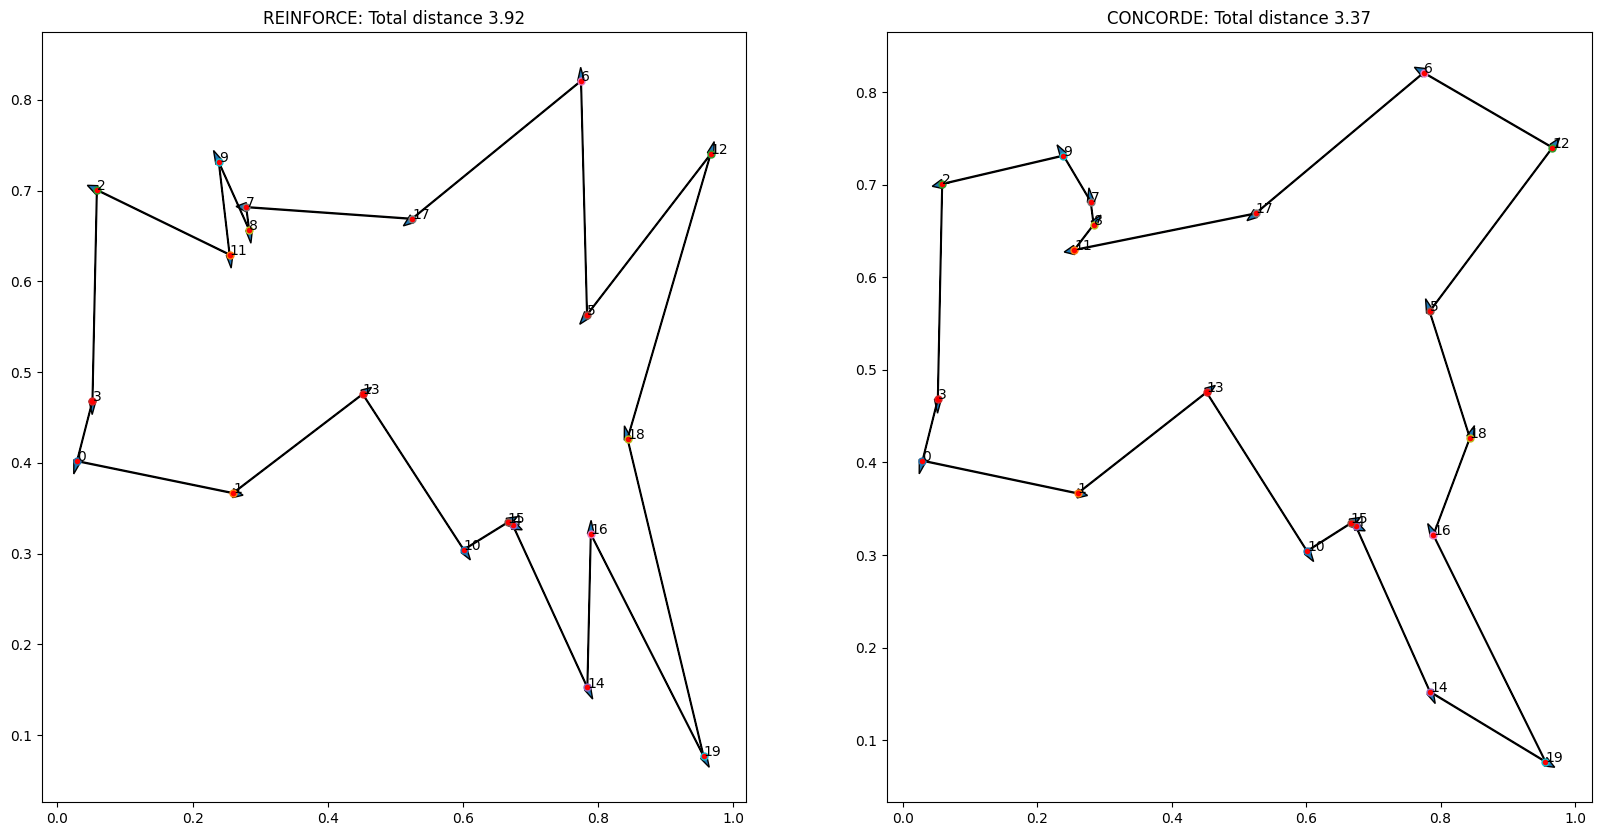

In [9]:
# batch[0].shape, tours.shape
# (torch.Size([20, 2]), torch.Size([1, 20]))

# plot the tsp results
plot_tsp(batch[0], tour, opt_tour, markersize=5)

In [10]:
# plot the tspd results
#NOTE Not implemented yet

print('REINFORCE TSPD Cost: {:.2f}'.format(tspd_cost))
print('CONCORDE TSPD Cost: {:.2f}'.format(opt_cost))

REINFORCE TSPD Cost: 2.33
CONCORDE TSPD Cost: 2.55
